# Compare MATLAB Files

This notebook compares two MATLAB .mat files and visualizes differences.

The visualization shows:
- **Row 1**: First file's first sample, three panes (Modulus, Density, Poisson's Ratio)
- **Row 2**: Second file's first sample, three panes
- **Row 3**: Differences between the two files


In [1]:
import numpy as np
import sys
from pathlib import Path
import h5py
import os
import matplotlib.pyplot as plt

# Custom utilities
try:
    import NO_utils
except ImportError as e:
    print(f"Error importing NO_utils: {e}")
    sys.exit(1)


In [2]:
def load_mat_data_safe(data_path):
    """
    Load MATLAB .mat file data, handling optional fields like rng_seed_offset.
    """
    with h5py.File(data_path, 'r') as file:
        EIGENVALUE_DATA = np.array(file['EIGENVALUE_DATA'])
        EIGENVECTOR_DATA_real = np.array(file['EIGENVECTOR_DATA']['real'])
        EIGENVECTOR_DATA_imag = np.array(file['EIGENVECTOR_DATA']['imag'])
        EIGENVECTOR_DATA = EIGENVECTOR_DATA_real + 1j * EIGENVECTOR_DATA_imag
        WAVEVECTOR_DATA = np.array(file['WAVEVECTOR_DATA'])
        
        const = {key: np.array(file['const'][key]) for key in file['const']}
        
        N_struct = np.array(file['N_struct'])
        design_params = np.array(file['design_params'])
        designs = np.array(file['designs'])
        imag_tol = np.array(file['imag_tol'])
        
        # Handle optional rng_seed_offset
        rng_seed_offset = None
        if 'rng_seed_offset' in file:
            rng_seed_offset = np.array(file['rng_seed_offset'])
    
    return {
        'EIGENVALUE_DATA': EIGENVALUE_DATA,
        'EIGENVECTOR_DATA': EIGENVECTOR_DATA,
        'WAVEVECTOR_DATA': WAVEVECTOR_DATA,
        'const': const,
        'N_struct': N_struct,
        'design_params': design_params,
        'designs': designs,
        'imag_tol': imag_tol,
        'rng_seed_offset': rng_seed_offset
    }


In [21]:
# File paths
file1_path = Path(r"D:\Research\NO-2D-Metamaterials\data\out_test_10_mat_original\out_binarized_1.mat")
#file2_path = Path(r"D:\Research\NO-2D-Metamaterials\data\out_test_10_mat_reconstructed\out_binarized_1.mat")
#file2_path = Path(r"D:\Research\NO-2D-Metamaterials\data\out_test_10_sanity_check_reconstruction\out_binarized_1.mat")
file2_path = Path(r"D:\Research\NO-2D-Metamaterials\data\out_test_10_sanity_check_reconstruction\out_binarized_1_regenerated.mat")

print(f"File 1: {file1_path}")
print(f"File 2: {file2_path}")


File 1: D:\Research\NO-2D-Metamaterials\data\out_test_10_mat_original\out_binarized_1.mat
File 2: D:\Research\NO-2D-Metamaterials\data\out_test_10_sanity_check_reconstruction\out_binarized_1_regenerated.mat


In [22]:
# Load both files
print("Loading file 1...")
data1 = load_mat_data_safe(file1_path)
designs1 = data1['designs']

print("Loading file 2...")
data2 = load_mat_data_safe(file2_path)
designs2 = data2['designs']

print(f"\nDesigns shape - File 1: {designs1.shape}")
print(f"Designs shape - File 2: {designs2.shape}")


Loading file 1...
Loading file 2...

Designs shape - File 1: (10, 3, 32, 32)
Designs shape - File 2: (10, 3, 32, 32)


In [23]:
# Extract first sample (design 0) from both files
sample_idx = 0
design1_sample = designs1[sample_idx, :, :, :]  # (3, H, W)
design2_sample = designs2[sample_idx, :, :, :]  # (3, H, W)

# Compute differences
design_diff = design1_sample - design2_sample

# Pane labels
pane_labels = ['Modulus', 'Density', "Poisson's Ratio"]

print(f"Sample {sample_idx} shape - File 1: {design1_sample.shape}")
print(f"Sample {sample_idx} shape - File 2: {design2_sample.shape}")
print(f"\nFile 1 value ranges:")
for pane_idx in range(3):
    print(f"  Pane {pane_idx} ({pane_labels[pane_idx]}): [{np.min(design1_sample[pane_idx]):.6e}, {np.max(design1_sample[pane_idx]):.6e}]")
print(f"\nFile 2 value ranges:")
for pane_idx in range(3):
    print(f"  Pane {pane_idx} ({pane_labels[pane_idx]}): [{np.min(design2_sample[pane_idx]):.6e}, {np.max(design2_sample[pane_idx]):.6e}]")
print(f"\nDifference ranges:")
for pane_idx in range(3):
    print(f"  Pane {pane_idx} ({pane_labels[pane_idx]}): [{np.min(design_diff[pane_idx]):.6e}, {np.max(design_diff[pane_idx]):.6e}]")


Sample 0 shape - File 1: (3, 32, 32)
Sample 0 shape - File 2: (3, 32, 32)

File 1 value ranges:
  Pane 0 (Modulus): [4.000400e-04, 1.000000e+00]
  Pane 1 (Density): [0.000000e+00, 1.000000e+00]
  Pane 2 (Poisson's Ratio): [6.000000e-01, 9.000000e-01]

File 2 value ranges:
  Pane 0 (Modulus): [7.999463e-04, 1.000000e+00]
  Pane 1 (Density): [4.000664e-04, 1.000000e+00]
  Pane 2 (Poisson's Ratio): [6.000000e-01, 8.998800e-01]

Difference ranges:
  Pane 0 (Modulus): [-3.999063e-04, 0.000000e+00]
  Pane 1 (Density): [-4.000664e-04, 0.000000e+00]
  Pane 2 (Poisson's Ratio): [0.000000e+00, 1.200199e-04]


In [24]:
# Compare design panes (modulus, density, poisson)
print("\n" + "=" * 80)
print("COMPARING DESIGN PANES")
print("=" * 80)

struct_idx = 0
design1_sample = designs1[struct_idx, :, :, :]  # (3, 32, 32)
design2_sample = designs2[struct_idx, :, :, :]  # (3, 32, 32)

pane_names = ['Modulus', 'Density', 'Poisson Ratio']
print(f"\nComparing first sample (struct_idx={struct_idx}):")
print(f"  Original shape: {design1_sample.shape}")
print(f"  Reconstructed shape: {design2_sample.shape}")

for pane_idx in range(3):
    pane_name = pane_names[pane_idx]
    orig_pane = design1_sample[pane_idx, :, :]
    recon_pane = design2_sample[pane_idx, :, :]
    
    diff = np.abs(orig_pane - recon_pane)
    rel_diff = diff / (np.abs(orig_pane) + 1e-20)
    
    print(f"\n  Pane {pane_idx} ({pane_name}):")
    print(f"    Original range: [{np.min(orig_pane):.6e}, {np.max(orig_pane):.6e}]")
    print(f"    Reconstructed range: [{np.min(recon_pane):.6e}, {np.max(recon_pane):.6e}]")
    print(f"    Max abs diff: {np.max(diff):.6e}")
    print(f"    Mean abs diff: {np.mean(diff):.6e}")
    print(f"    Max rel diff: {np.max(rel_diff):.6e}")
    print(f"    Mean rel diff: {np.mean(rel_diff):.6e}")
    
    if np.max(diff) < 1e-6:
        print(f"    [MATCH] Exact match (within 1e-6)")
    elif np.max(rel_diff) < 1e-5:
        print(f"    [MATCH] Close match (within 1e-5 relative)")
    else:
        print(f"    [DIFFERENT] Significant difference")



COMPARING DESIGN PANES

Comparing first sample (struct_idx=0):
  Original shape: (3, 32, 32)
  Reconstructed shape: (3, 32, 32)

  Pane 0 (Modulus):
    Original range: [4.000400e-04, 1.000000e+00]
    Reconstructed range: [7.999463e-04, 1.000000e+00]
    Max abs diff: 3.999063e-04
    Mean abs diff: 1.218465e-04
    Max rel diff: 9.996659e-01
    Mean rel diff: 3.045857e-01
    [DIFFERENT] Significant difference

  Pane 1 (Density):
    Original range: [0.000000e+00, 1.000000e+00]
    Reconstructed range: [4.000664e-04, 1.000000e+00]
    Max abs diff: 4.000664e-04
    Mean abs diff: 1.218952e-04
    Max rel diff: 4.000664e+16
    Mean rel diff: 1.218952e+16
    [DIFFERENT] Significant difference

  Pane 2 (Poisson Ratio):
    Original range: [6.000000e-01, 9.000000e-01]
    Reconstructed range: [6.000000e-01, 8.998800e-01]
    Max abs diff: 1.200199e-04
    Mean abs diff: 3.656857e-05
    Max rel diff: 1.333555e-04
    Mean rel diff: 4.063174e-05
    [DIFFERENT] Significant differenc

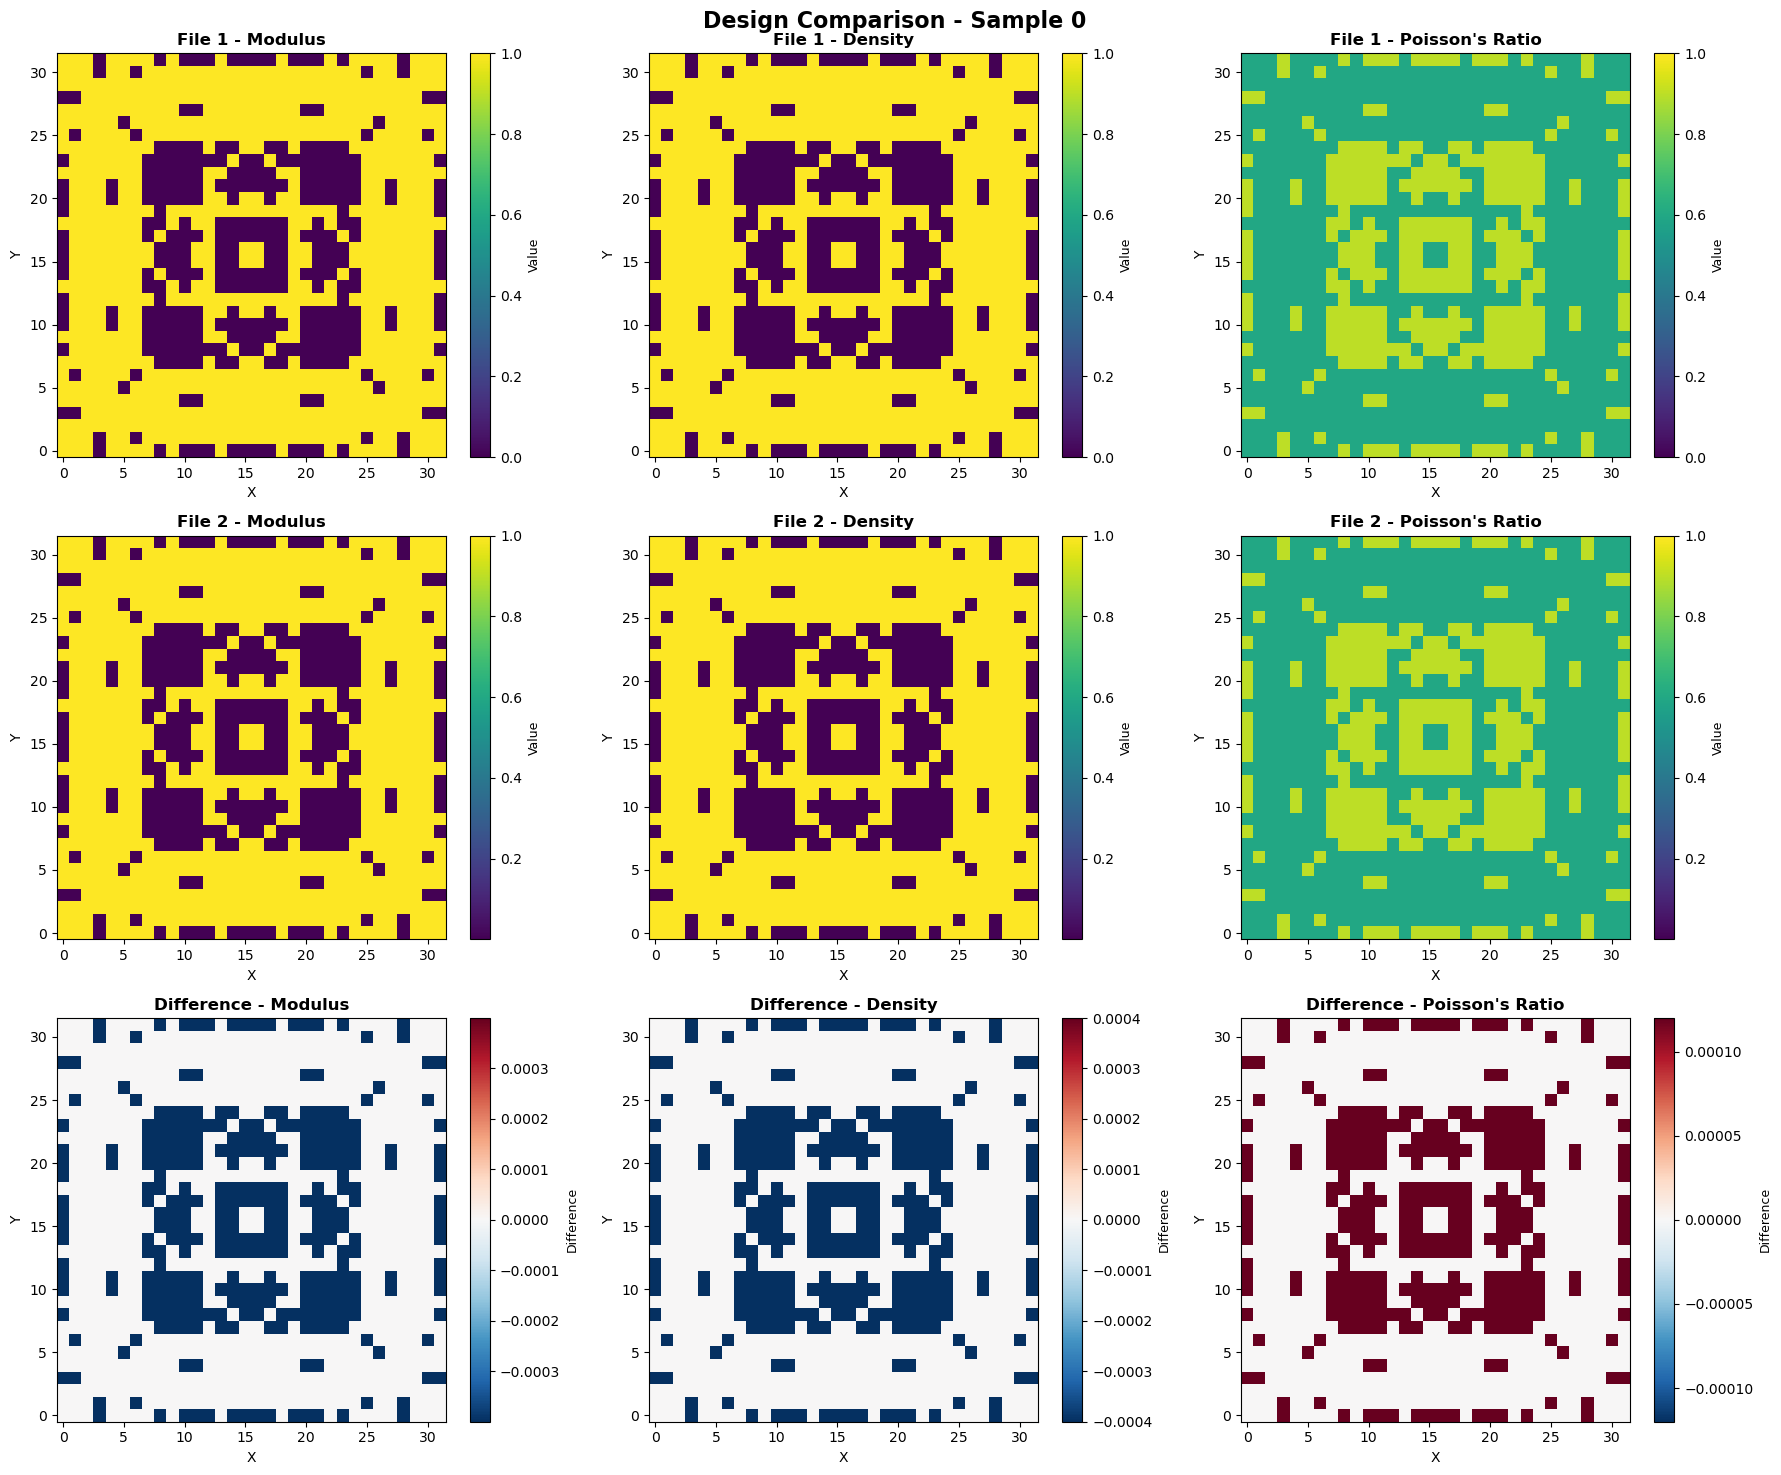

In [25]:
# Create 3x3 subplot visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle(f'Design Comparison - Sample {sample_idx}', fontsize=16, fontweight='bold')

# Compute shared colorbar ranges for rows 1 and 2 (for better comparison)
vmin_row1 = min(np.min(design1_sample[pane_idx]) for pane_idx in range(3))
vmax_row1 = max(np.max(design1_sample[pane_idx]) for pane_idx in range(3))
vmin_row2 = min(np.min(design2_sample[pane_idx]) for pane_idx in range(3))
vmax_row2 = max(np.max(design2_sample[pane_idx]) for pane_idx in range(3))

# Row 1: File 1 (original)
for pane_idx in range(3):
    ax = axes[0, pane_idx]
    im = ax.imshow(design1_sample[pane_idx], cmap='viridis', origin='lower', aspect='auto', 
                   vmin=vmin_row1, vmax=vmax_row1)
    ax.set_title(f'File 1 - {pane_labels[pane_idx]}', fontsize=12, fontweight='bold')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Value', fontsize=9)

# Row 2: File 2 (reconstructed)
for pane_idx in range(3):
    ax = axes[1, pane_idx]
    im = ax.imshow(design2_sample[pane_idx], cmap='viridis', origin='lower', aspect='auto',
                   vmin=vmin_row2, vmax=vmax_row2)
    ax.set_title(f'File 2 - {pane_labels[pane_idx]}', fontsize=12, fontweight='bold')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Value', fontsize=9)

# Row 3: Differences
for pane_idx in range(3):
    ax = axes[2, pane_idx]
    # Use a diverging colormap for differences
    vmax = np.max(np.abs(design_diff[pane_idx]))
    vmin = -vmax if vmax > 0 else 0
    im = ax.imshow(design_diff[pane_idx], cmap='RdBu_r', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    ax.set_title(f'Difference - {pane_labels[pane_idx]}', fontsize=12, fontweight='bold')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Difference', fontsize=9)

plt.tight_layout()
plt.show()


In [26]:
# Summary statistics
print("=" * 80)
print("Comparison Summary")
print("=" * 80)
print(f"\nDesign array shapes: {designs1.shape} vs {designs2.shape}")
print(f"Shapes match: {designs1.shape == designs2.shape}")

for pane_idx in range(3):
    print(f"\nPane {pane_idx} ({pane_labels[pane_idx]}):")
    pane1 = designs1[:, pane_idx, :, :]
    pane2 = designs2[:, pane_idx, :, :]
    
    abs_diff = np.abs(pane1 - pane2)
    max_abs_diff = np.max(abs_diff)
    mean_abs_diff = np.mean(abs_diff)
    
    # Handle division by zero for relative diff
    mask_nonzero = np.abs(pane1) > 1e-10
    if mask_nonzero.sum() > 0:
        rel_diff = abs_diff[mask_nonzero] / np.abs(pane1[mask_nonzero])
        max_rel_diff = np.max(rel_diff)
        mean_rel_diff = np.mean(rel_diff)
    else:
        max_rel_diff = 0
        mean_rel_diff = 0
    
    is_close = np.allclose(pane1, pane2, rtol=1e-5, atol=1e-8)
    
    print(f"  Match: {'✓' if is_close else '✗'}")
    if not is_close:
        print(f"  Max abs diff: {max_abs_diff:.6e}")
        print(f"  Mean abs diff: {mean_abs_diff:.6e}")
        print(f"  Max rel diff: {max_rel_diff:.6e}")
        print(f"  Mean rel diff: {mean_rel_diff:.6e}")
        print(f"  File 1 range: [{np.min(pane1):.6e}, {np.max(pane1):.6e}]")
        print(f"  File 2 range: [{np.min(pane2):.6e}, {np.max(pane2):.6e}]")


Comparison Summary

Design array shapes: (10, 3, 32, 32) vs (10, 3, 32, 32)
Shapes match: True

Pane 0 (Modulus):
  Match: ✗
  Max abs diff: 3.999063e-04
  Mean abs diff: 1.838632e-04
  Max rel diff: 9.996659e-01
  Mean rel diff: 4.596120e-01
  File 1 range: [4.000400e-04, 1.000000e+00]
  File 2 range: [7.999463e-04, 1.000000e+00]

Pane 1 (Density):
  Match: ✗
  Max abs diff: 4.000664e-04
  Mean abs diff: 1.839368e-04
  Max rel diff: 0.000000e+00
  Mean rel diff: 0.000000e+00
  File 1 range: [0.000000e+00, 1.000000e+00]
  File 2 range: [4.000664e-04, 1.000000e+00]

Pane 2 (Poisson's Ratio):
  Match: ✗
  Max abs diff: 1.200199e-04
  Mean abs diff: 5.518103e-05
  Max rel diff: 1.333555e-04
  Mean rel diff: 6.131226e-05
  File 1 range: [6.000000e-01, 9.000000e-01]
  File 2 range: [6.000000e-01, 8.998800e-01]


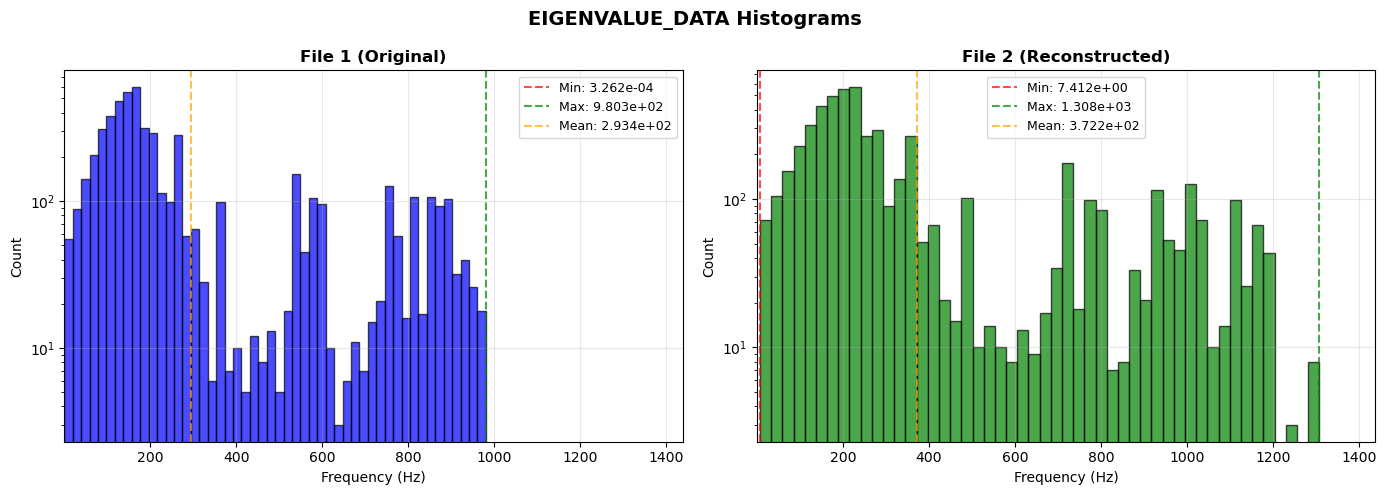


EIGENVALUE_DATA Statistics:
File 1 - Count: 5460, Min: 3.261936e-04, Max: 9.803106e+02, Mean: 2.934259e+02
File 2 - Count: 5460, Min: 7.412463e+00, Max: 1.307838e+03, Mean: 3.722163e+02


In [27]:
# Extract EIGENVALUE_DATA for both files
EIGENVALUE_DATA1 = data1['EIGENVALUE_DATA']
EIGENVALUE_DATA2 = data2['EIGENVALUE_DATA']

# Flatten for histogram (excluding NaN values)
ev1_flat = EIGENVALUE_DATA1.flatten()
ev2_flat = EIGENVALUE_DATA2.flatten()
ev1_valid = ev1_flat[~np.isnan(ev1_flat)]
ev2_valid = ev2_flat[~np.isnan(ev2_flat)]

# Create side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('EIGENVALUE_DATA Histograms', fontsize=14, fontweight='bold')

# File 1 histogram
ax1 = axes[0]
ax1.hist(ev1_valid, bins=50, edgecolor='black', alpha=0.7, color='blue')
ax1.set_title('File 1 (Original)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Frequency (Hz)', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.axvline(np.min(ev1_valid), color='red', linestyle='--', alpha=0.7, label=f'Min: {np.min(ev1_valid):.3e}')
ax1.axvline(np.max(ev1_valid), color='green', linestyle='--', alpha=0.7, label=f'Max: {np.max(ev1_valid):.3e}')
ax1.axvline(np.mean(ev1_valid), color='orange', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(ev1_valid):.3e}')
ax1.legend(fontsize=9)
ax1.set_yscale('log')

# File 2 histogram
ax2 = axes[1]
ax2.hist(ev2_valid, bins=50, edgecolor='black', alpha=0.7, color='green')
ax2.set_title('File 2 (Reconstructed)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Frequency (Hz)', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axvline(np.min(ev2_valid), color='red', linestyle='--', alpha=0.7, label=f'Min: {np.min(ev2_valid):.3e}')
ax2.axvline(np.max(ev2_valid), color='green', linestyle='--', alpha=0.7, label=f'Max: {np.max(ev2_valid):.3e}')
ax2.axvline(np.mean(ev2_valid), color='orange', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(ev2_valid):.3e}')
ax2.legend(fontsize=9)
ax2.set_yscale('log')

# Use shared x-axis range for better comparison
x_min = min(np.min(ev1_valid), np.min(ev2_valid))
x_max = max(np.max(ev1_valid), np.max(ev2_valid))
ax1.set_xlim([x_min * 0.9, x_max * 1.1])
ax2.set_xlim([x_min * 0.9, x_max * 1.1])

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nEIGENVALUE_DATA Statistics:")
print(f"File 1 - Count: {len(ev1_valid)}, Min: {np.min(ev1_valid):.6e}, Max: {np.max(ev1_valid):.6e}, Mean: {np.mean(ev1_valid):.6e}")
print(f"File 2 - Count: {len(ev2_valid)}, Min: {np.min(ev2_valid):.6e}, Max: {np.max(ev2_valid):.6e}, Mean: {np.mean(ev2_valid):.6e}")



In [28]:
# Load eigenvectors for random index combinations
# This helps verify that eigenvectors are correctly mapped back to their original indices

import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Get dimensions
EIGENVECTOR_DATA1 = data1['EIGENVECTOR_DATA']
EIGENVECTOR_DATA2 = data2['EIGENVECTOR_DATA']

n_designs = EIGENVECTOR_DATA1.shape[0]
n_bands = EIGENVECTOR_DATA1.shape[1]
n_wavevectors = EIGENVECTOR_DATA1.shape[2]
n_dof = EIGENVECTOR_DATA1.shape[3]

# Get design_res from designs array
design_res = designs1.shape[2]  # designs shape: (n_designs, 3, design_res, design_res)

print(f"EIGENVECTOR_DATA shapes:")
print(f"  Original: {EIGENVECTOR_DATA1.shape}")
print(f"  Reconstructed: {EIGENVECTOR_DATA2.shape}")
print(f"\nDimensions: {n_designs} designs, {n_bands} bands, {n_wavevectors} wavevectors, {n_dof} DOF")
print(f"Design resolution: {design_res} x {design_res}")

# Verify n_dof matches expected
expected_dof = 2 * design_res * design_res
if n_dof != expected_dof:
    print(f"⚠ WARNING: n_dof ({n_dof}) != expected (2*{design_res}*{design_res}={expected_dof})")

# Randomly select 5 index combinations
n_samples = 5
random_indices = []
for _ in range(n_samples):
    struct_idx = random.randint(0, n_designs - 1)
    band_idx = random.randint(0, n_bands - 1)
    wv_idx = random.randint(0, n_wavevectors - 1)
    random_indices.append((struct_idx, band_idx, wv_idx))

print(f"\nRandomly selected {n_samples} index combinations:")
for i, (s, b, w) in enumerate(random_indices):
    print(f"  Sample {i+1}: struct_idx={s}, band_idx={b}, wv_idx={w}")

# Extract eigenvectors for each combination
eigenvectors_orig = []
eigenvectors_recon = []

for struct_idx, band_idx, wv_idx in random_indices:
    eigvec_orig = EIGENVECTOR_DATA1[struct_idx, band_idx, wv_idx, :]
    eigvec_recon = EIGENVECTOR_DATA2[struct_idx, band_idx, wv_idx, :]
    eigenvectors_orig.append(eigvec_orig)
    eigenvectors_recon.append(eigvec_recon)

print(f"\nExtracted {len(eigenvectors_orig)} eigenvector pairs")
print(f"Each eigenvector shape: {eigenvectors_orig[0].shape}")

# Helper function to split and reshape eigenvectors to 2D
def reshape_eigenvector_to_2d(eigvec, design_res):
    """
    Split interleaved eigenvector into x and y components and reshape to 2D.
    
    Parameters:
    -----------
    eigvec : np.ndarray
        1D eigenvector array with interleaved x and y components [x0, y0, x1, y1, ...]
    design_res : int
        Design resolution (spatial grid size)
    
    Returns:
    --------
    eigvec_x_2d : np.ndarray
        2D array of x-component displacements (design_res, design_res)
    eigvec_y_2d : np.ndarray
        2D array of y-component displacements (design_res, design_res)
    """
    # Split into x and y components (even indices = x, odd indices = y)
    eigvec_x = eigvec[0::2]  # x components
    eigvec_y = eigvec[1::2]  # y components
    
    # Reshape to 2D spatial grid
    eigvec_x_2d = eigvec_x.reshape(design_res, design_res)
    eigvec_y_2d = eigvec_y.reshape(design_res, design_res)
    
    return eigvec_x_2d, eigvec_y_2d


EIGENVECTOR_DATA shapes:
  Original: (10, 6, 91, 2048)
  Reconstructed: (10, 6, 91, 2048)

Dimensions: 10 designs, 6 bands, 91 wavevectors, 2048 DOF
Design resolution: 32 x 32

Randomly selected 5 index combinations:
  Sample 1: struct_idx=1, band_idx=0, wv_idx=35
  Sample 2: struct_idx=3, band_idx=1, wv_idx=17
  Sample 3: struct_idx=1, band_idx=5, wv_idx=69
  Sample 4: struct_idx=1, band_idx=4, wv_idx=54
  Sample 5: struct_idx=0, band_idx=0, wv_idx=11

Extracted 5 eigenvector pairs
Each eigenvector shape: (2048,)


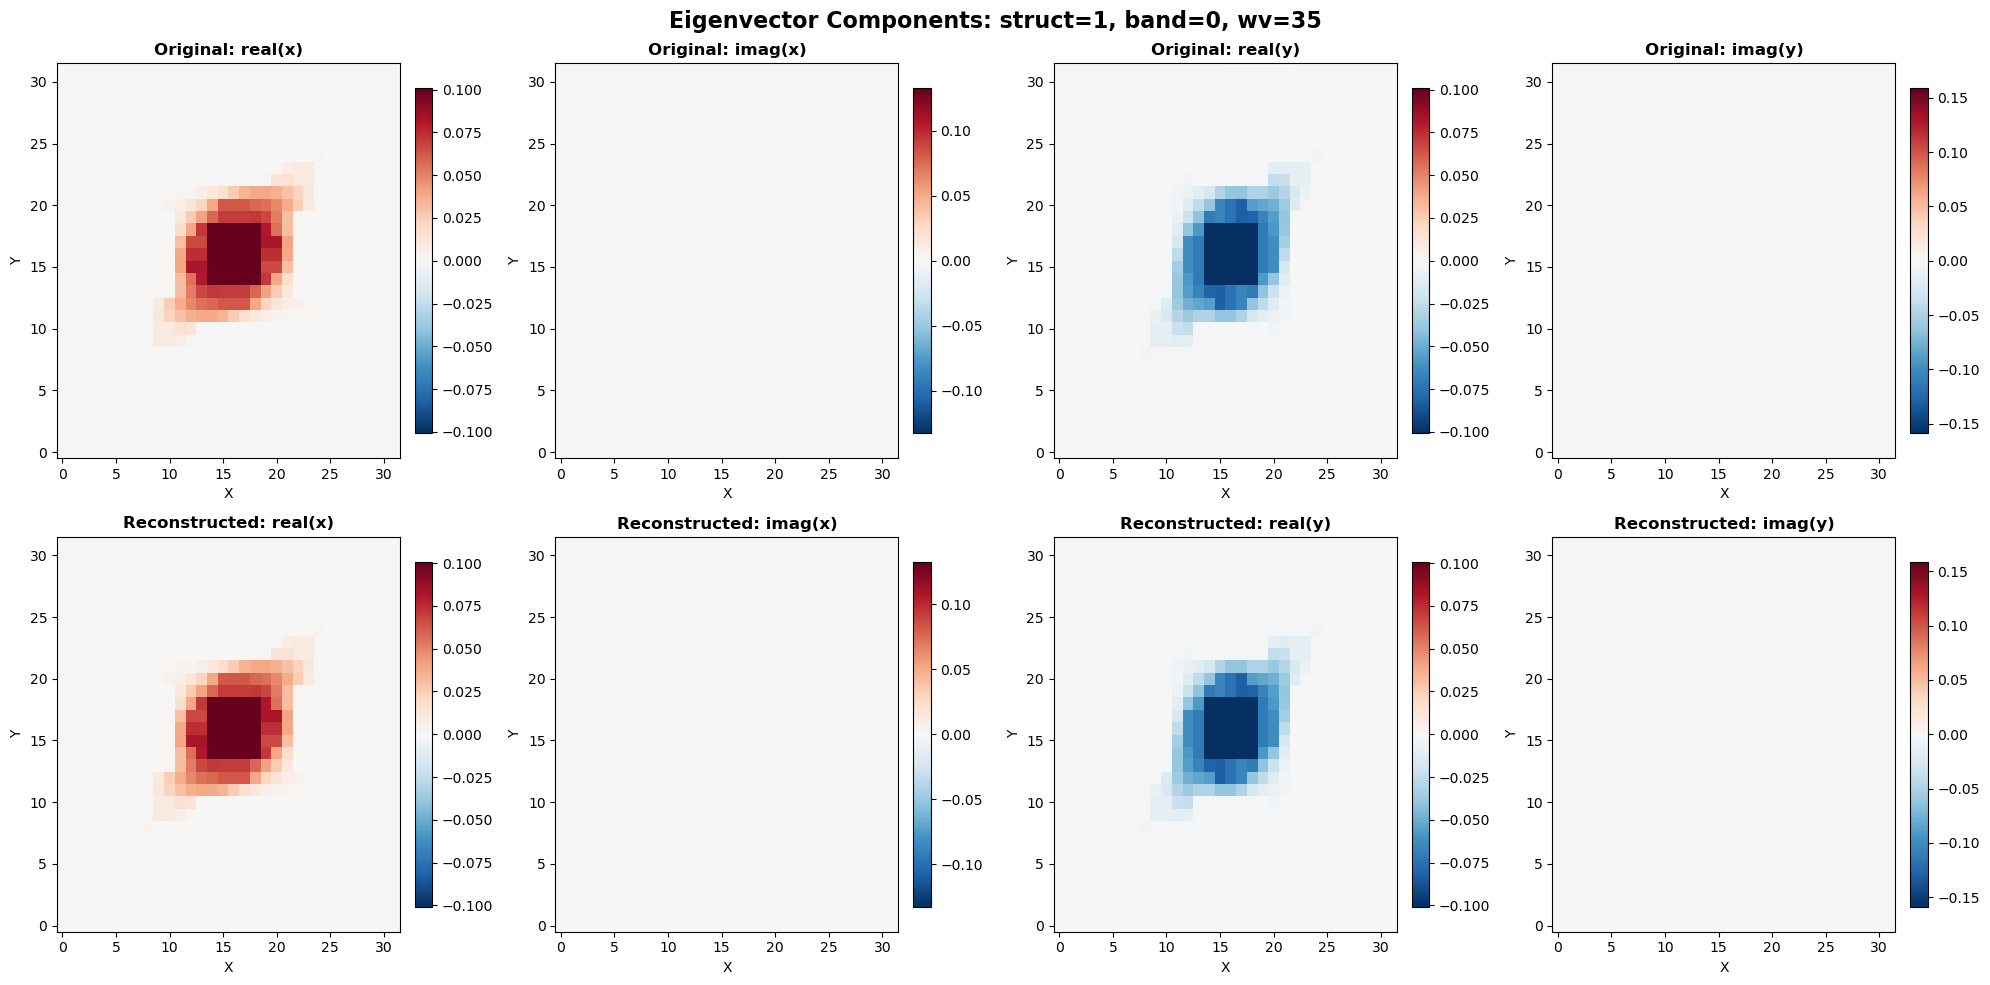

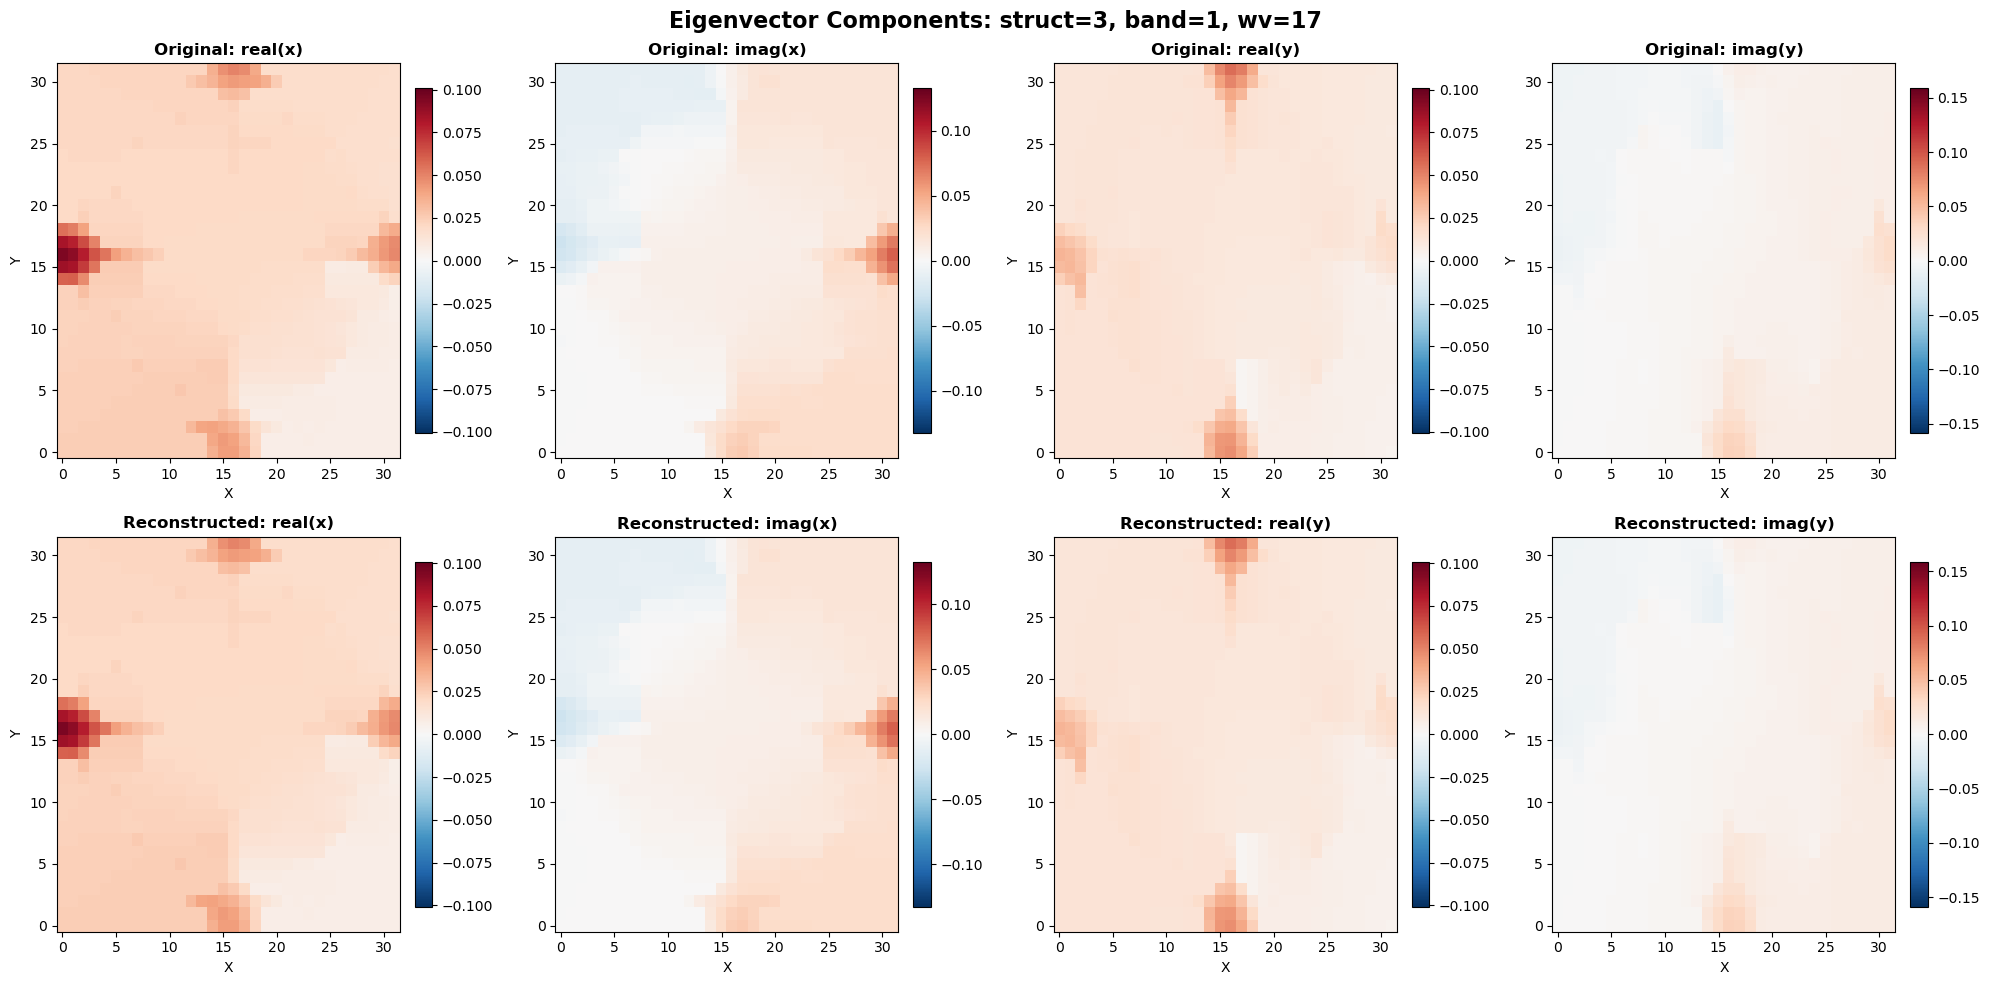

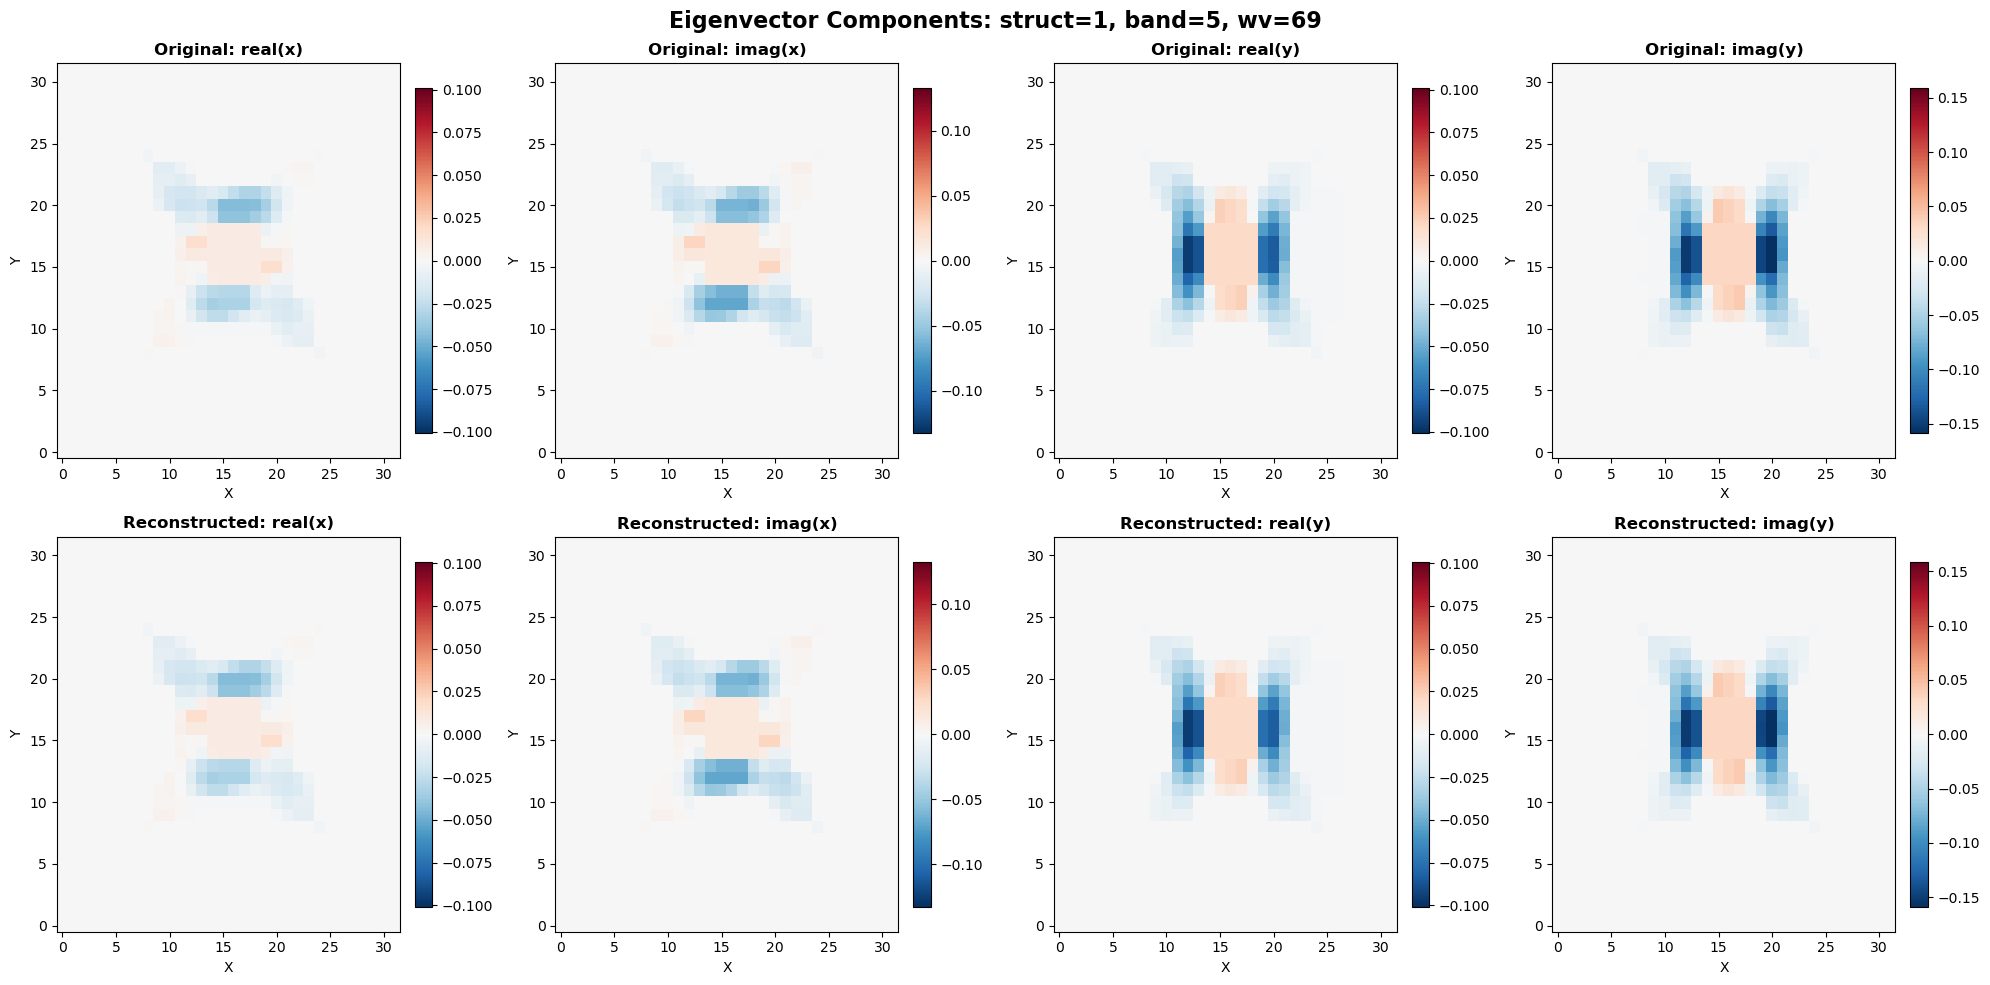

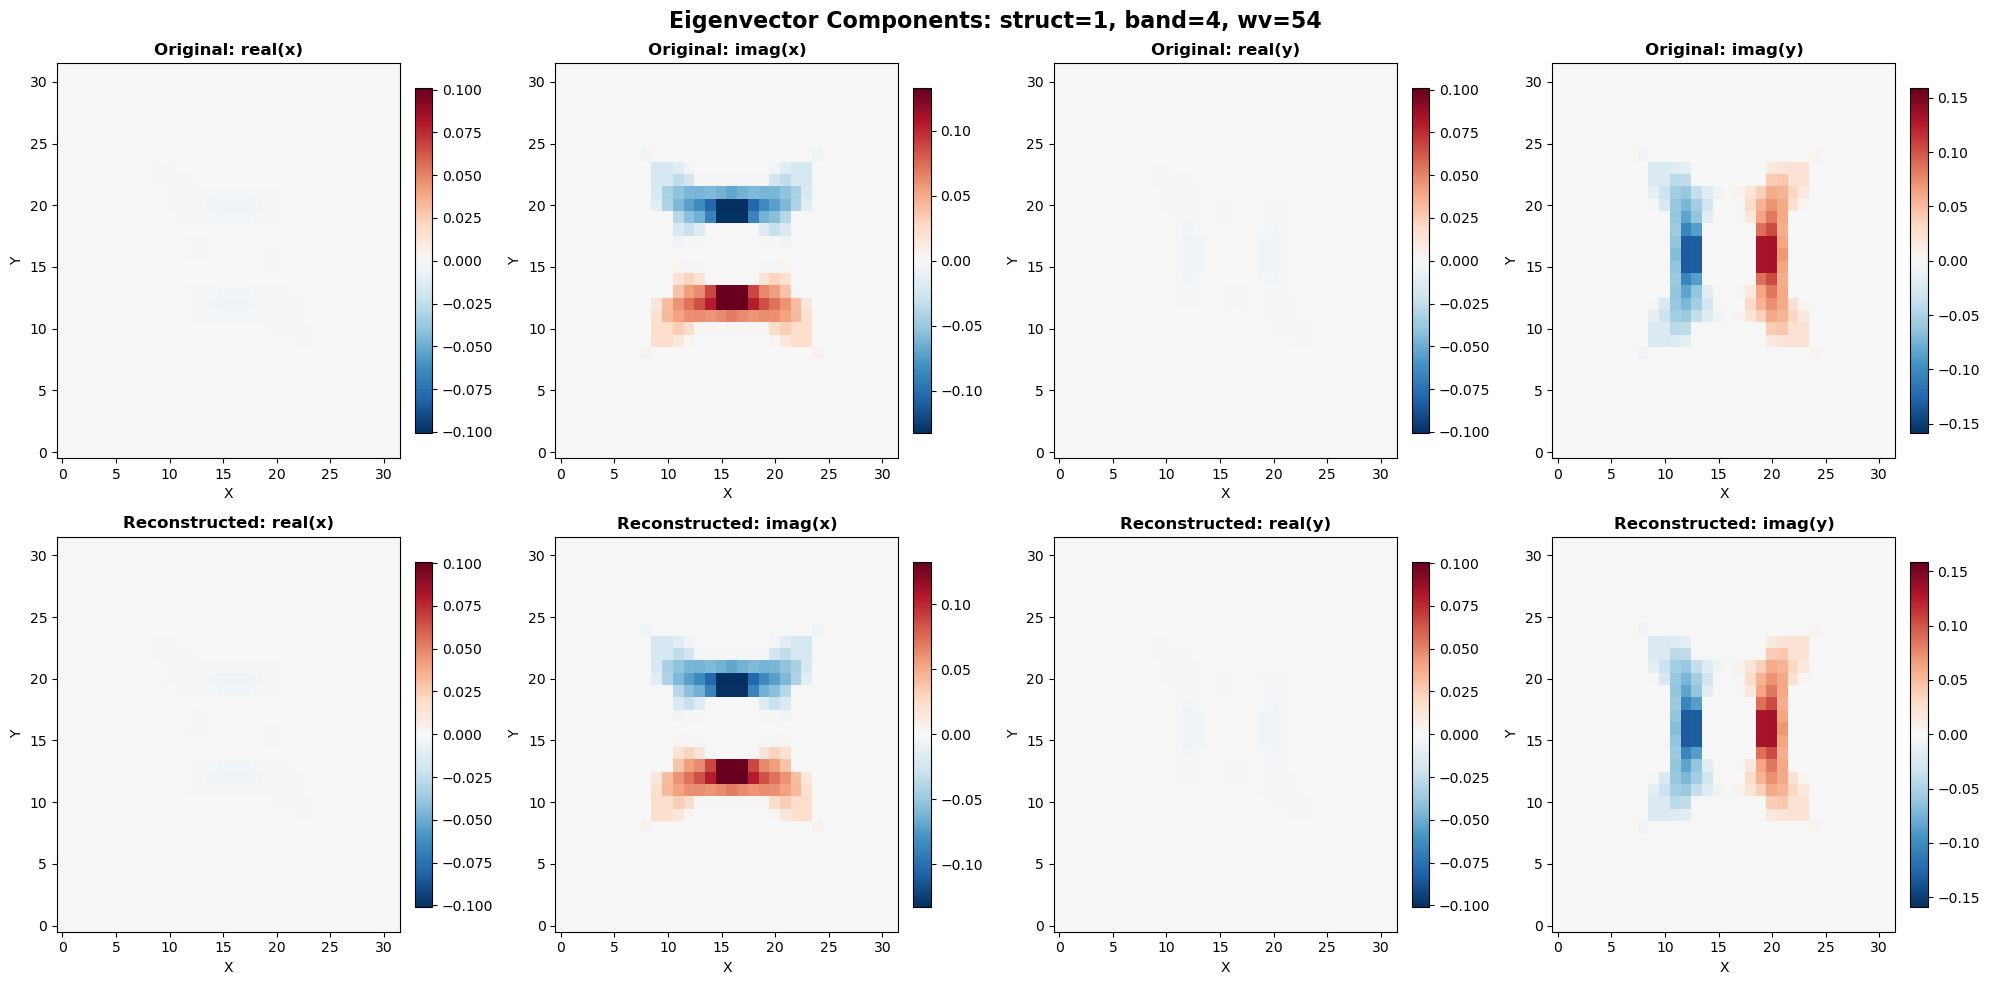

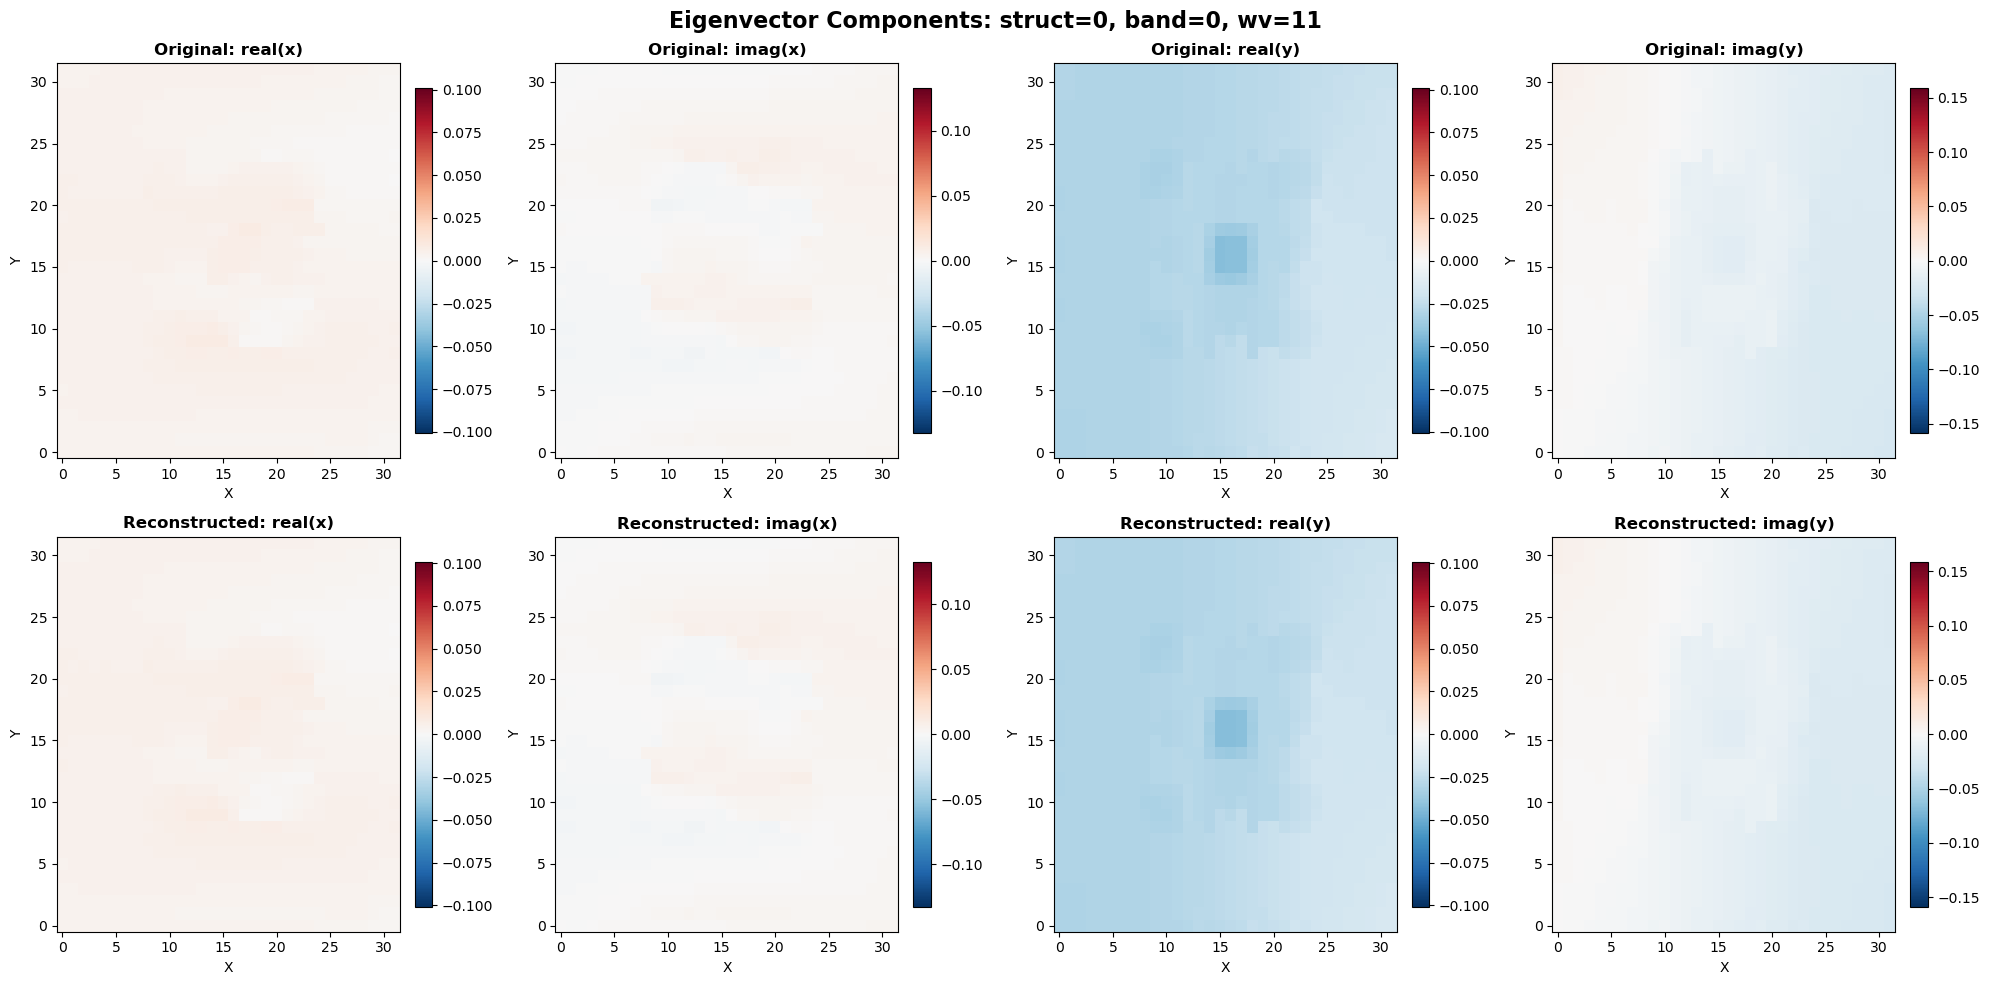

EIGENVECTOR COMPARISON STATISTICS

Sample 1 (struct=1, band=0, wv=35):
  Max absolute difference: 2.991409e-05
  Mean absolute difference: 1.356736e-06
  Max relative difference: 4.252541e-04
  Mean relative difference: 1.822310e-04
  Original norm: 1.000000e+00
  Reconstructed norm: 9.999462e-01

Sample 2 (struct=3, band=1, wv=17):
  Max absolute difference: 2.530036e-05
  Mean absolute difference: 3.672980e-06
  Max relative difference: 4.605189e-04
  Mean relative difference: 1.795509e-04
  Original norm: 1.000000e+00
  Reconstructed norm: 1.000003e+00

Sample 3 (struct=1, band=5, wv=69):
  Max absolute difference: 6.033636e-05
  Mean absolute difference: 1.286421e-06
  Max relative difference: 1.210580e-03
  Mean relative difference: 1.934982e-04
  Original norm: 9.999999e-01
  Reconstructed norm: 9.999757e-01

Sample 4 (struct=1, band=4, wv=54):
  Max absolute difference: 2.864840e-05
  Mean absolute difference: 1.062386e-06
  Max relative difference: 6.232529e-04
  Mean relative 

In [29]:
# Plot all 4 components (real(x), imag(x), real(y), imag(y)) for each eigenvector
# Each eigenvector gets its own figure with:
#   Top row: 4 components for original
#   Bottom row: 4 components for reconstructed
# Total: 5 figures (one for each randomly selected eigenvector)

n_plots = len(random_indices)  # Plot all 5 samples

# First, compute shared colorbar ranges across all components for better comparison
all_real_x_orig = []
all_imag_x_orig = []
all_real_y_orig = []
all_imag_y_orig = []
all_real_x_recon = []
all_imag_x_recon = []
all_real_y_recon = []
all_imag_y_recon = []

for col_idx in range(n_plots):
    eigvec_orig = eigenvectors_orig[col_idx]
    eigvec_recon = eigenvectors_recon[col_idx]
    x_orig, y_orig = reshape_eigenvector_to_2d(eigvec_orig, design_res)
    x_recon, y_recon = reshape_eigenvector_to_2d(eigvec_recon, design_res)
    
    all_real_x_orig.append(np.real(x_orig))
    all_imag_x_orig.append(np.imag(x_orig))
    all_real_y_orig.append(np.real(y_orig))
    all_imag_y_orig.append(np.imag(y_orig))
    all_real_x_recon.append(np.real(x_recon))
    all_imag_x_recon.append(np.imag(x_recon))
    all_real_y_recon.append(np.real(y_recon))
    all_imag_y_recon.append(np.imag(y_recon))

# Compute shared colorbar ranges for each component type
def compute_vmin_vmax(all_arrays):
    """Compute vmin and vmax for a list of arrays."""
    all_values = []
    for arr in all_arrays:
        all_values.extend(arr.flatten())
    if len(all_values) > 0:
        vmin = np.min(all_values)
        vmax = np.max(all_values)
        # Make symmetric if needed for better visualization
        vmax_abs = max(abs(vmin), abs(vmax))
        return -vmax_abs, vmax_abs
    return 0, 1

vmin_real_x, vmax_real_x = compute_vmin_vmax(all_real_x_orig + all_real_x_recon)
vmin_imag_x, vmax_imag_x = compute_vmin_vmax(all_imag_x_orig + all_imag_x_recon)
vmin_real_y, vmax_real_y = compute_vmin_vmax(all_real_y_orig + all_real_y_recon)
vmin_imag_y, vmax_imag_y = compute_vmin_vmax(all_imag_y_orig + all_imag_y_recon)

# Plot each eigenvector in a separate figure
for col_idx in range(n_plots):
    struct_idx, band_idx, wv_idx = random_indices[col_idx]
    eigvec_orig = eigenvectors_orig[col_idx]
    eigvec_recon = eigenvectors_recon[col_idx]
    
    # Reshape to 2D
    x_orig, y_orig = reshape_eigenvector_to_2d(eigvec_orig, design_res)
    x_recon, y_recon = reshape_eigenvector_to_2d(eigvec_recon, design_res)
    
    # Extract real and imaginary parts
    real_x_orig = np.real(x_orig)
    imag_x_orig = np.imag(x_orig)
    real_y_orig = np.real(y_orig)
    imag_y_orig = np.imag(y_orig)
    
    real_x_recon = np.real(x_recon)
    imag_x_recon = np.imag(x_recon)
    real_y_recon = np.real(y_recon)
    imag_y_recon = np.imag(y_recon)
    
    # Create figure with 2 rows × 4 columns
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'Eigenvector Components: struct={struct_idx}, band={band_idx}, wv={wv_idx}', 
                 fontsize=16, fontweight='bold')
    
    # Top row: Original (4 components)
    # Column 0: real(x)
    ax = axes[0, 0]
    im = ax.imshow(real_x_orig, cmap='RdBu_r', origin='lower', aspect='auto', 
                   vmin=vmin_real_x, vmax=vmax_real_x)
    ax.set_title('Original: real(x)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Column 1: imag(x)
    ax = axes[0, 1]
    im = ax.imshow(imag_x_orig, cmap='RdBu_r', origin='lower', aspect='auto', 
                   vmin=vmin_imag_x, vmax=vmax_imag_x)
    ax.set_title('Original: imag(x)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Column 2: real(y)
    ax = axes[0, 2]
    im = ax.imshow(real_y_orig, cmap='RdBu_r', origin='lower', aspect='auto', 
                   vmin=vmin_real_y, vmax=vmax_real_y)
    ax.set_title('Original: real(y)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Column 3: imag(y)
    ax = axes[0, 3]
    im = ax.imshow(imag_y_orig, cmap='RdBu_r', origin='lower', aspect='auto', 
                   vmin=vmin_imag_y, vmax=vmax_imag_y)
    ax.set_title('Original: imag(y)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Bottom row: Reconstructed (4 components)
    # Column 0: real(x)
    ax = axes[1, 0]
    im = ax.imshow(real_x_recon, cmap='RdBu_r', origin='lower', aspect='auto', 
                   vmin=vmin_real_x, vmax=vmax_real_x)
    ax.set_title('Reconstructed: real(x)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Column 1: imag(x)
    ax = axes[1, 1]
    im = ax.imshow(imag_x_recon, cmap='RdBu_r', origin='lower', aspect='auto', 
                   vmin=vmin_imag_x, vmax=vmax_imag_x)
    ax.set_title('Reconstructed: imag(x)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Column 2: real(y)
    ax = axes[1, 2]
    im = ax.imshow(real_y_recon, cmap='RdBu_r', origin='lower', aspect='auto', 
                   vmin=vmin_real_y, vmax=vmax_real_y)
    ax.set_title('Reconstructed: real(y)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Column 3: imag(y)
    ax = axes[1, 3]
    im = ax.imshow(imag_y_recon, cmap='RdBu_r', origin='lower', aspect='auto', 
                   vmin=vmin_imag_y, vmax=vmax_imag_y)
    ax.set_title('Reconstructed: imag(y)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Print comparison statistics
print("=" * 80)
print("EIGENVECTOR COMPARISON STATISTICS")
print("=" * 80)
for col_idx in range(n_plots):
    struct_idx, band_idx, wv_idx = random_indices[col_idx]
    eigvec_orig = eigenvectors_orig[col_idx]
    eigvec_recon = eigenvectors_recon[col_idx]
    
    diff = np.abs(eigvec_orig - eigvec_recon)
    rel_diff = diff / (np.abs(eigvec_orig) + 1e-20)
    
    print(f"\nSample {col_idx+1} (struct={struct_idx}, band={band_idx}, wv={wv_idx}):")
    print(f"  Max absolute difference: {np.max(diff):.6e}")
    print(f"  Mean absolute difference: {np.mean(diff):.6e}")
    print(f"  Max relative difference: {np.max(rel_diff):.6e}")
    print(f"  Mean relative difference: {np.mean(rel_diff):.6e}")
    print(f"  Original norm: {np.linalg.norm(eigvec_orig):.6e}")
    print(f"  Reconstructed norm: {np.linalg.norm(eigvec_recon):.6e}")
